<center><h1><font color='orange'>Generating Synthetic Faces Using Generative Adversarial Networks</font></h1></center>
<center><h3>By: Adam Lieberman</h3></center>
<br>
<br>
<h4>Introduction:</h4>
<p>Generative Adversarial Networks (GANs) can be used to generate synthetic input data. Here, two neural networks compete against each other in a zero-sum game framework. The generator generates synthetic input from a particular distribution of interest while the discriminator simultaneously tries to discriminate between the synthesized instances and the isntances from the true data distribution. Each network controls each others loss function, i.e. the generator's training objective is to increase the error rate of the discriminator network. This means that the generator is trying to trick the discriminator into producing new synthetic instances that appear to have come from the true data distribution. In this lesson, we will use a generative adversarial network to construct synthetic facial images.</p>
<br>
<h4>Library Imports:</h4>
<p>We start by importing the following libraries:</p>

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy
from sklearn.datasets import fetch_lfw_people
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import random

<h4>Data:</h4>
<p>We will be using the Labeled Faces in the Wild (LFW) database. This consists of more than 13,000 images of faces collected from the web. Additionally, each face comes with a label representing the name of the person pictured. To learn more about the dataset please refer to this <a href="http://vis-www.cs.umass.edu/lfw/">link</a>. Here you can learn more about the data and download it to your machine. This data is also available through sklearn using the fetch_lfw_people function. Here we can specify a slice to extract a facial image and resize the each of the images to our desired shape. We load the data as follows:</p>

In [3]:
lfw_people = fetch_lfw_people(slice_=(slice(70, 195, None), slice(70, 195, None)), resize=0.224) 
data = lfw_people.data 

print("Data Shape: ",data.shape)
num_images, num_pixels = data.shape
print("number of images: %d" % num_images)
print("number of pixels per image: %d" % num_pixels)

Data Shape:  (13233, 784)
number of images: 13233
number of pixels per image: 784


<p>We see that we have 13,233 facial images that are shape 28 x 28, which is flattened into a one dimensional vector of length 784. Additionally, we note that these images are grayscale. We can visualize a few of the original images from our dataset below:</p>

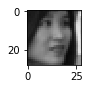

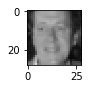

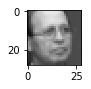

In [4]:
%matplotlib inline
plt.figure(figsize=(1,1))
im = Image.fromarray(data[4].reshape(28,28))
p = plt.imshow(im)
plt.show(p)

%matplotlib inline
plt.figure(figsize=(1,1))
p1 = plt.imshow(Image.fromarray(data[45].reshape(28,28)))
plt.show(p1)

%matplotlib inline
plt.figure(figsize=(1,1))
p2 = plt.imshow(Image.fromarray(data[599].reshape(28,28)))
plt.show(p2)

<h4>Deep Convolutional Generative Adversarial Networks:</h4>
<p>In 2016 Alec Radford, Luke Metz, and Soumith Chintala published <a href="https://arxiv.org/pdf/1511.06434.pdf">Unsupervised Representation Learning With Deep Convolutional
Generative Adversarial Networks</a>. In computer vision tasks, convolutional networks and supervised learning has had great success and popularity. However, unsupervised learning with convolutional neural networks has recieved less attention. Deep Convolutional Generative Adversarial Networks (DCGANs) demonstrate that they are a strong candidate for unsupervised learning. The generator/discriminator pair learns a hierarchy of representations from object parts to scenes in both the generator and discriminator. Since we are working with facial image data, implementing a DCGAN is a great choice. The architecture from the paper is as follows:</p>
<ul>
<li>Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator)</li>
<li>Use batchnorm in both the generator and the discriminator</li>
<li>Remove fully connected hidden layers for deeper architectures</li>
<li>Use ReLU activation in generator for all layers except for the output, which uses Tanh</li>
<li>Use LeakyReLU activation in the discriminator for all layers</li>
</ul>
<p>To build our DCGAN, we will use TensorFlow-Slim. This will allow us to build a complex network while keeping the model's architecure transparent.</p>

<h4>LeakyReLU layer:</h4>
<p>When we use GANs we want to avoid sparse gradients to prevent suffering in terms of GAN stability. This means we should stear clear from ReLU and MaxPool. Instead we can use a LeakyReLU layer. Let us create one that we will call in our discriminator. We build it as follows:</p>

In [22]:
#Create a LeakyReLU, good in both G and D
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

<h4>Generator:</h4>
<p>Let us now use tensorflow and create our generator network. Our architecture is as follows:</p>
<ul>
<li>Fully Connected Layer</li>
<li>Reshape</li>
<li>Convolutional Layer 1 - batch normalization, relu activation</li>
<li>Convolutional Layer 2 - batch normalization, relu activation</li>
<li>Convolutional Layer 3 - batch normalization, relu activation</li>
<li>Convolutional Layer 4 - batch normalization, tanh activation</li>
</ul>
<p>We construct these layers in our generator as follows:</p>

In [5]:
def generator(z):
    zP = slim.fully_connected(z,4*4*256,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    
    zCon = tf.reshape(zP,[-1,4,4,256])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    
    return g_out

<p>We have now created our generator.</p>

<h4>Discriminator:</h4>
<p>Our discriminator will have the following architecture:</p>

In [7]:
def discriminator(bottom, reuse=False):
    dis1 = slim.convolution2d(bottom,16,[4,4],stride=[2,2],padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv1',weights_initializer=initializer)
    
    dis2 = slim.convolution2d(dis1,32,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv2', weights_initializer=initializer)
    
    dis3 = slim.convolution2d(dis2,64,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv3',weights_initializer=initializer)
    
    d_out = slim.fully_connected(slim.flatten(dis3),1,activation_fn=tf.nn.sigmoid,\
        reuse=reuse,scope='d_out', weights_initializer=initializer)
    
    return d_out

In [8]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

<h4>Save Generated Images:</h4>
<p>Let us now write a function to save our generated images. Here we will take in a vector of images, a size, and a path to save them. This will return us a block of images (6 x 6) so we can see how our model improves over time.We do so as follows:</p>

In [20]:
def save_generated_images(images,size,image_path): 
    images = (images+1.)/2.
    height = images.shape[1]
    width = images.shape[2]
    img = np.zeros((height * size[0], width * size[1]))
    for idx, image in enumerate(images):
        a = idx % size[1]
        b = idx // size[1]
        img[b*height:b*height+height, a*width:a*width+width] = image
    sve = scipy.misc.imsave(image_path,img)
    return sve

In [21]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 5000 #Total number of iterations to use.
sample_directory = './album_art_figs' #Directory to save sample images from generator in.
model_directory = './album_art_models' #Directory to save trained model to.

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
        print("Progress: ",i,"/",iterations)
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        r = random.sample(range(data.shape[0]), batch_size)
        xs = data[r]
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1))
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 10 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_generated_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

Progress:  0 / 5000
Gen Loss: 0.364692 Disc Loss: 1.58653
Progress:  1 / 5000
Progress:  2 / 5000
Progress:  3 / 5000


KeyboardInterrupt: 